In [53]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [54]:
#change the tickers here according to what's in the portfolio
tickers = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [55]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LHX     1259 non-null   float64
 1   ODFL    1259 non-null   float64
 2   GLDD    1259 non-null   float64
 3   HSON    1259 non-null   float64
 4   ISSC    1259 non-null   float64
 5   KRNT    1259 non-null   float64
 6   RCII    1259 non-null   float64
 7   SAIA    1259 non-null   float64
 8   AMD     1259 non-null   float64
 9   EPAM    1259 non-null   float64
 10  APPS    1259 non-null   float64
 11  ASML    1259 non-null   float64
 12  AUDC    1259 non-null   float64
 13  DSGX    1259 non-null   float64
 14  TTD     1259 non-null   float64
 15  TSLA    1259 non-null   float64
 16  CHDN    1259 non-null   float64
 17  CLAR    1259 non-null   float64
 18  FIVE    1259 non-null   float64
 19  FOXF    1259 non-null   float64
 20  HTHT    1259 non-null   float64
 21  LULU    1259 non-nu

## Function that saves dataframe to CSV

In [56]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [57]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
# #     close = panel_data['Close']
#     adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [58]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [59]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [60]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [61]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [62]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [63]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [64]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [65]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC']

#add in the weightage of stocks
port_shares = [0.0131472,0.0956672,0.0070288,0.0141824,0.0021888,0.0143296,0.0129904,0.0004672,
               0.0127696,0.0160512,0.0500096,0.03064,0.0250672,0.001824,0.02364,0.0486736,0.0130144,
               0.0343008,0.0058128,0.012288,0.0064912,0.0394192,0.0375584,0.0064432,0.02008,0.0013888,
               0.0128944,0.0041264,0.034536,0.0360544,0.0069216,0.16]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,CDMO,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.232730,5.423164,0.031630,0.201390,0.006550,0.189867,0.136867,0.020977,0.145957,1.021819,...,0.031808,0.004639,0.963341,0.148179,0.083922,1.123095,0.034400,16.564933,41.511308,NaN
2017-01-04,1.239451,5.445661,0.033035,0.208481,0.006607,0.184852,0.138278,0.021047,0.145957,1.033055,...,0.032868,0.004708,0.990548,0.150160,0.082886,1.164557,0.033362,16.588478,41.788370,0.006674
2017-01-05,1.241011,5.381292,0.031419,0.207063,0.006814,0.179120,0.131811,0.020533,0.143530,1.039315,...,0.031808,0.004694,0.982682,0.147849,0.083922,1.193761,0.034193,16.368722,41.519803,-0.006427
2017-01-06,1.254692,5.380668,0.031278,0.204227,0.006776,0.181269,0.126402,0.020968,0.144552,1.073344,...,0.031808,0.004736,1.014145,0.147808,0.083922,1.193401,0.034262,16.249426,41.553027,0.000800
2017-01-09,1.225770,5.351296,0.030575,0.198554,0.007058,0.191300,0.127108,0.020604,0.146723,1.072862,...,0.031808,0.004875,1.036323,0.147395,0.081850,1.165999,0.035646,16.166233,41.481355,-0.001725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,2.753131,33.986757,0.110704,0.394980,0.014030,2.197587,0.639128,0.155601,1.971115,11.187686,...,0.607822,0.007500,3.966575,0.940407,2.187856,9.657531,0.152621,61.203560,264.581641,0.022235
2021-12-28,2.777084,34.086155,0.109930,0.399660,0.014446,2.184547,0.635620,0.154265,1.955664,10.950129,...,0.587942,0.007638,3.946331,0.900793,2.097371,9.149525,0.151860,61.422280,263.222672,-0.005136
2021-12-29,2.779833,34.484706,0.110071,0.397958,0.014315,2.212204,0.641206,0.156704,1.893221,10.880146,...,0.608625,0.007416,3.971346,0.909747,2.054547,9.298430,0.148814,61.457407,263.688527,0.001770


## Get old data for portfolio

In [66]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,CDMO,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.232730,5.423164,0.031630,0.201390,0.006550,0.189867,0.136867,0.020977,0.145957,1.021819,...,0.031808,0.004639,0.963341,0.148179,0.083922,1.123095,0.034400,16.564933,41.511308,NaN
2017-01-04,1.239451,5.445661,0.033035,0.208481,0.006607,0.184852,0.138278,0.021047,0.145957,1.033055,...,0.032868,0.004708,0.990548,0.150160,0.082886,1.164557,0.033362,16.588478,41.788370,0.006674
2017-01-05,1.241011,5.381292,0.031419,0.207063,0.006814,0.179120,0.131811,0.020533,0.143530,1.039315,...,0.031808,0.004694,0.982682,0.147849,0.083922,1.193761,0.034193,16.368722,41.519803,-0.006427
2017-01-06,1.254692,5.380668,0.031278,0.204227,0.006776,0.181269,0.126402,0.020968,0.144552,1.073344,...,0.031808,0.004736,1.014145,0.147808,0.083922,1.193401,0.034262,16.249426,41.553027,0.000800
2017-01-09,1.225770,5.351296,0.030575,0.198554,0.007058,0.191300,0.127108,0.020604,0.146723,1.072862,...,0.031808,0.004875,1.036323,0.147395,0.081850,1.165999,0.035646,16.166233,41.481355,-0.001725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,2.753131,33.986757,0.110704,0.394980,0.014030,2.197587,0.639128,0.155601,1.971115,11.187686,...,0.607822,0.007500,3.966575,0.940407,2.187856,9.657531,0.152621,61.203560,264.581641,0.022235
2021-12-28,2.777084,34.086155,0.109930,0.399660,0.014446,2.184547,0.635620,0.154265,1.955664,10.950129,...,0.587942,0.007638,3.946331,0.900793,2.097371,9.149525,0.151860,61.422280,263.222672,-0.005136
2021-12-29,2.779833,34.484706,0.110071,0.397958,0.014315,2.212204,0.641206,0.156704,1.893221,10.880146,...,0.608625,0.007416,3.971346,0.909747,2.054547,9.298430,0.148814,61.457407,263.688527,0.001770


## Forecasting

In [67]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [68]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [69]:
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,CDMO,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.232730,5.423164,0.031630,0.201390,0.006550,0.189867,0.136867,0.020977,0.145957,1.021819,...,0.031808,0.004639,0.963341,0.148179,0.083922,1.123095,0.034400,16.564933,41.511308,NaN
2017-01-04,1.239451,5.445661,0.033035,0.208481,0.006607,0.184852,0.138278,0.021047,0.145957,1.033055,...,0.032868,0.004708,0.990548,0.150160,0.082886,1.164557,0.033362,16.588478,41.788370,0.006674
2017-01-05,1.241011,5.381292,0.031419,0.207063,0.006814,0.179120,0.131811,0.020533,0.143530,1.039315,...,0.031808,0.004694,0.982682,0.147849,0.083922,1.193761,0.034193,16.368722,41.519803,-0.006427
2017-01-06,1.254692,5.380668,0.031278,0.204227,0.006776,0.181269,0.126402,0.020968,0.144552,1.073344,...,0.031808,0.004736,1.014145,0.147808,0.083922,1.193401,0.034262,16.249426,41.553027,0.000800
2017-01-07,1.254692,5.380668,0.031278,0.204227,0.006776,0.181269,0.126402,0.020968,0.144552,1.073344,...,0.031808,0.004736,1.014145,0.147808,0.083922,1.193401,0.034262,16.249426,41.553027,0.000800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,2.753131,33.986757,0.110704,0.394980,0.014030,2.197587,0.639128,0.155601,1.971115,11.187686,...,0.607822,0.007500,3.966575,0.940407,2.187856,9.657531,0.152621,61.203560,264.581641,0.022235
2021-12-28,2.777084,34.086155,0.109930,0.399660,0.014446,2.184547,0.635620,0.154265,1.955664,10.950129,...,0.587942,0.007638,3.946331,0.900793,2.097371,9.149525,0.151860,61.422280,263.222672,-0.005136
2021-12-29,2.779833,34.484706,0.110071,0.397958,0.014315,2.212204,0.641206,0.156704,1.893221,10.880146,...,0.608625,0.007416,3.971346,0.909747,2.054547,9.298430,0.148814,61.457407,263.688527,0.001770


In [70]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [71]:
tot_port_df

,Total
Date,
2017-01-03,41.511308
2017-01-04,41.788370
2017-01-05,41.519803
2017-01-06,41.553027
2017-01-07,41.553027
...,...
2021-12-27,264.581641
2021-12-28,263.222672
2021-12-29,263.688527


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1824


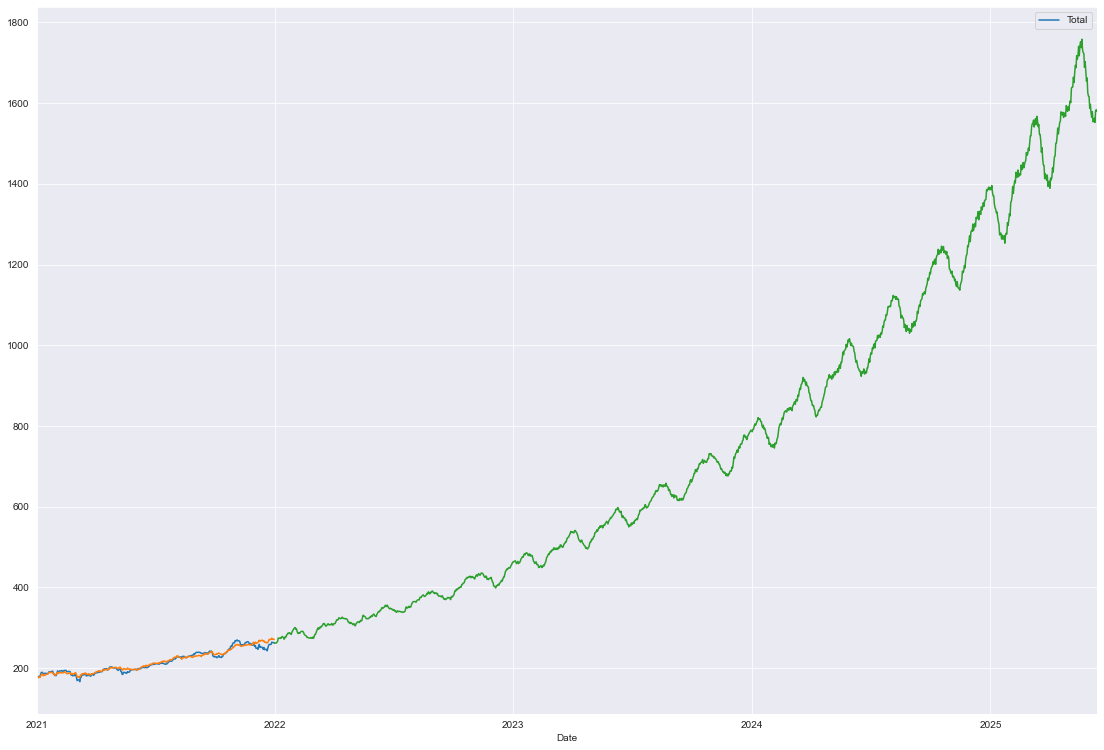

In [72]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [73]:
forecast

2021-12-31     262.304335
2022-01-01     262.408845
2022-01-02     262.026251
2022-01-03     262.426362
2022-01-04     264.505594
                 ...     
2025-06-09    1562.463492
2025-06-10    1552.245690
2025-06-11    1580.553351
2025-06-12    1583.814918
2025-06-13    1580.219582
Freq: D, Length: 1261, dtype: float64

In [74]:
forecast_df = pd.DataFrame(forecast)

In [75]:
forecast_df

,0
2021-12-31,262.304335
2022-01-01,262.408845
2022-01-02,262.026251
2022-01-03,262.426362
2022-01-04,264.505594
...,...
2025-06-09,1562.463492
2025-06-10,1552.245690
2025-06-11,1580.553351
2025-06-12,1583.814918


In [79]:
forecast_df.to_csv('stocks_80%.csv')

In [76]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [77]:
return_series

,0
2021-12-31,NaN
2022-01-01,0.000398
2022-01-02,-0.001060
2022-01-03,0.000465
2022-01-04,0.008392
...,...
2025-06-09,4.956682
2025-06-10,4.917728
2025-06-11,5.025647
2025-06-12,5.038081


In [78]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1/5))-1

print(annualized_return*100)

                    0
2025-06-13  43.212984
